In [1]:
from insight_analyzer import *
# notebook input from an insight
analyzer = ForecastAnalyzer(
    result_id="1634d18b1580d69cb38bde5216316833d090641e",
    workspace="6dc62a5d50124f0dae3b0db307289ad1"
)

Let us fetch the dataframe from the server.

In [2]:
df = analyzer.get_df()

Let's start by preprocessing our dataframe, so `Autoreg` from `sklearn` package can accept it:

In [3]:
# Convert PeriodIndex to DateTimeIndex
if isinstance(df.index, pd.PeriodIndex):
    df.index = df.index.to_timestamp()

# Prepare the data (get the time series column)
column_name = df.columns[0]
time_series = df[column_name]

Okay, now let's set up the fitted model. For this we need to set up lags, which is a parameter denoting, how many past datapoints influence the forecast of next one.

In [4]:
from statsmodels.tsa.ar_model import AutoReg

# Number of quarters to use to predict the next quarter
lags = 8 # 2 years

# Train the AutoRegressive model
model = AutoReg(time_series, lags=lags)
model_fitted = model.fit()

Now let's forecast our data.

In [5]:
# Number of steps to predict
steps = 12 # 3 years

# Confidence interval:
conf_int = 90

forecast_obj = model_fitted.get_prediction(start=len(time_series), end=len(time_series) + steps - 1)
forecast = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int(alpha=(100-conf_int)/100)

It is better to concise the data, so it would be easier to work with.

In [6]:
result_df = pd.DataFrame({
        "forecast": forecast,
        "lower_bound": conf_int.iloc[:, 0],
        "upper_bound": conf_int.iloc[:, 1]
    })

Okay, now just plot it.
Notice, that the last of the original datapoints is not connected to the new one.

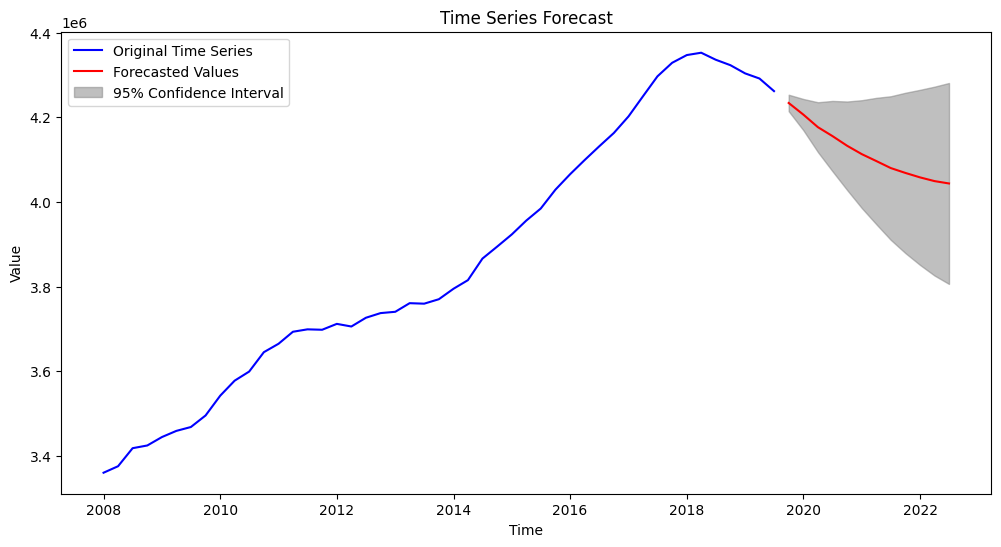

In [7]:
column_name = df.columns[0]

# Plot the original time series data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df[column_name], label='Original Time Series', color='blue')

# Plot the forecasted values
plt.plot(result_df.index, result_df['forecast'], label='Forecasted Values', color='red')

# Plot the confidence intervals
plt.fill_between(result_df.index, result_df['lower_bound'], result_df['upper_bound'], color='gray', alpha=0.5, label='95% Confidence Interval')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Forecast')
plt.legend()

# Show plot
plt.show()

To fix this gap, simply add the last datapoint point of the original dataframe to the new one.

In [8]:
# Adding the last point of the input dataframe to the result dataframe
last_value = time_series.iloc[-1]
last_date = time_series.index[-1]
new_row = pd.DataFrame({
    "forecast": [last_value],
    "lower_bound": [last_value],
    "upper_bound": [last_value]
}, index=[last_date])

# Append the new row at the beginning of the result dataframe
result_df = pd.concat([new_row, result_df])

Now let's see how it looks when connected.

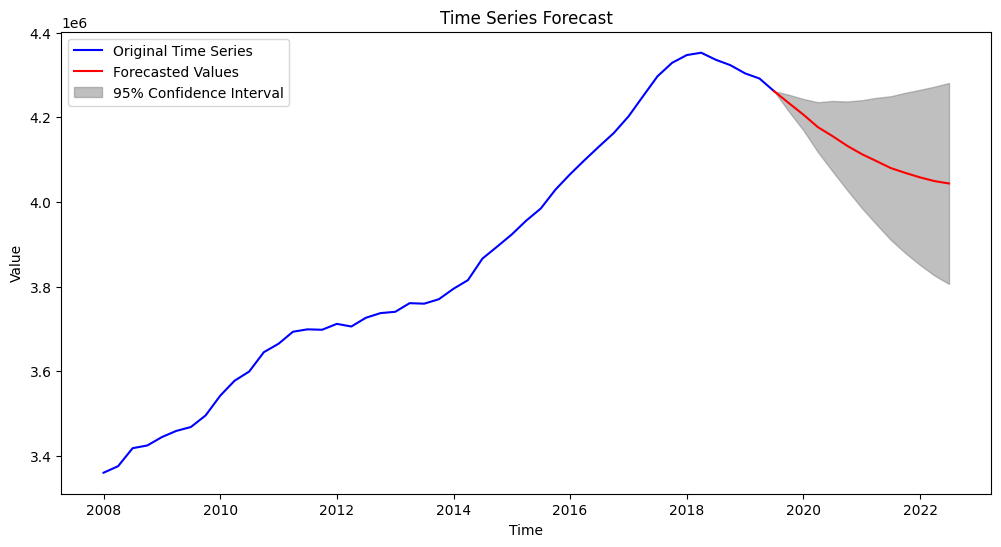

In [9]:
column_name = df.columns[0]

# Plot the original time series data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df[column_name], label='Original Time Series', color='blue')

# Plot the forecasted values
plt.plot(result_df.index, result_df['forecast'], label='Forecasted Values', color='red')

# Plot the confidence intervals
plt.fill_between(result_df.index, result_df['lower_bound'], result_df['upper_bound'], color='gray', alpha=0.5, label='95% Confidence Interval')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Forecast')
plt.legend()

# Show plot
plt.show()

Awesome! Last thing to do now is to push it to the server, so we can see it on our dashboard.

In [10]:
analyzer.push_to_server(result_df, df)

Success!
